## **IDX Exchange Home Price Prediction**
## **Task 2: Baseline Model Selection, Training & Evaluation**

#### Imports & Setup

In [1]:
import warnings, json, math
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import loguniform, randint

import joblib
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import export_text

#### Load the cleaned data 

In [2]:
csv_path = "../data/cleaned_enhanced.csv" if Path("../data/cleaned_enhanced.csv").exists() else "data/cleaned_enhanced.csv"
df = pd.read_csv(csv_path)

print(f"Original dataset shape: {df.shape}")

Original dataset shape: (78396, 83)


#### Resolve target column

In [3]:
target_candidates = ["ClosePrice", "Close Price", "Close_Price", "CLOSEPRICE"]
target = next((c for c in target_candidates if c in df.columns), None)
assert target is not None, "Target column not found in cleaned_enhanced.csv"

y_all = pd.to_numeric(df[target], errors="coerce")

#### CRITICAL: Remove leakage features FIRST

In [4]:
# List-related leakage (directly correlated with close price)
LEAKAGE_LIST_FEATURES = [
    "ListPrice", "List Price", "List_Price", "LISTPRICE",
    "ListPricePerSqft", "ListPricePerSqFt", "List_Price_Per_SqFt",
    "OriginalListPrice", "Original List Price", "Original_List_Price",
    "LP_to_SP_Ratio", "PriceDelta", "PricePctDiff",
    "SaleToListRatio", "SPLP", "SP_LP_Ratio",
    "ListPriceLow", "ListPriceHigh"
]

# Date/temporal leakage (info not available before sale)
LEAKAGE_DATE_FEATURES = [
    "CloseDate", "Close Date", "Close_Date", "CLOSEDATE",
    "CloseOfEscrowDate", "COEDate", "COE",
    "ModificationTimestamp", "ContractDate", "ListingContractDate",
    "DaysOnMarket", "DOM", "CDOM", "CumulativeDaysOnMarket",
    "RecordingDate", "PurchaseContractDate"
]

# High-cardinality identifiers (enable memorization)
LEAKAGE_IDS = [
    "ListingKey", "ListingId", "ListingID", "L_ListingID", 
    "Matrix_Unique_ID", "UniversalPropertyId", "L_DisplayId",
    "MLSNumber", "MLS#", "MLS_Number",
    "Address", "StreetAddress", "UnparsedAddress",
    "StreetName", "StreetNumber", "StreetDirPrefix", "StreetDirSuffix",
    "PhotoURL", "Photos", "VirtualTourURL"
]

# Free text (not useful, high cardinality)
LEAKAGE_TEXT = [
    "PublicRemarks", "PrivateRemarks", "Remarks",
    "Directions", "ShowingInstructions",
    "ElementarySchool", "MiddleSchool", "HighSchool"  # can be high-card
]

# Target-derived features (created from ClosePrice)
LEAKAGE_TARGET_DERIVED = [
    "PricePerSqft", "ClosePricePerSqFt", "Price_Per_SqFt",
    "SalePricePerSqFt"
]

ALL_LEAKAGE = (LEAKAGE_LIST_FEATURES + LEAKAGE_DATE_FEATURES + 
               LEAKAGE_IDS + LEAKAGE_TEXT + LEAKAGE_TARGET_DERIVED)

In [5]:
# Case-insensitive matching
drop_cols = []
for col in df.columns:
    if col == target:
        continue
    if any(leak.lower() == col.lower() for leak in ALL_LEAKAGE):
        drop_cols.append(col)

print(f"Dropping {len(drop_cols)} leakage features:")
for col in sorted(drop_cols):
    print(f"  - {col}")

X_all = df.drop(columns=[target] + drop_cols).copy()

Dropping 12 leakage features:
  - CloseDate
  - DaysOnMarket
  - ElementarySchool
  - HighSchool
  - ListPrice
  - ListPricePerSqft
  - ListingContractDate
  - ListingId
  - ListingKey
  - OriginalListPrice
  - PurchaseContractDate
  - UnparsedAddress


#### TIME-BASED SPLIT (Critical Fix!)

In [6]:
# Find date column for splitting - prioritize actual date columns
date_candidates = [
    "CloseDate", "Close Date", "Close_Date", "CLOSEDATE",
    "CloseOfEscrowDate", "COEDate", "COE",
    "SaleDate", "Sale Date", "Sale_Date",
    "Period", "period", "Month", "SaleMonth", "month",
    "StatusChangeTimestamp", "OnMarketTimestamp"
]

date_col = None
for col in date_candidates:
    if col in df.columns:
        date_col = col
        print(f"Found date column: '{date_col}'")
        # Show sample values
        sample_vals = df[col].dropna().head(5).tolist()
        print(f"Sample values: {sample_vals}")
        break

if date_col is None:
    print("\nNo suitable date column found.")
    print("Available columns in dataset:")
    for col in sorted(df.columns):
        print(f"  - {col}")
    raise ValueError(
        "No date/period column found for time-based split. "
        "Cannot proceed without temporal information."
    )

print(f"\nUsing date column: '{date_col}'")

Found date column: 'CloseDate'
Sample values: ['2025-08-11', '2025-08-29', '2025-08-29', '2025-08-30', '2025-08-29']

Using date column: 'CloseDate'


In [7]:
# Parse date - handle both full dates and period formats
print("Attempting to parse dates...")

# For actual date columns (not Period/Month columns)
if date_col.lower() not in {"period", "month", "salemonth"}:
    df["_date_sort"] = pd.to_datetime(df[date_col], errors="coerce")
    valid_count = df["_date_sort"].notna().sum()
    print(f"Parsed {valid_count} dates as datetime")
else:
    # For period/month columns
    s = df[date_col].astype(str).str.strip()
    
    # Try YYYY-MM format first
    df["_date_sort"] = pd.to_datetime(s, format="%Y-%m", errors="coerce")
    if df["_date_sort"].isna().all():
        # Try YYYYMM format
        s_clean = s.str.replace(r"[^\d]", "", regex=True)
        df["_date_sort"] = pd.to_datetime(s_clean, format="%Y%m", errors="coerce")
    
    valid_count = df["_date_sort"].notna().sum()
    print(f"Parsed {valid_count} dates from period format")

# Verify parsing worked
if df["_date_sort"].isna().all():
    print(f"\nERROR: Could not parse any dates from column '{date_col}'")
    print(f"Sample raw values: {df[date_col].head(10).tolist()}")
    raise ValueError(f"Date parsing failed for column '{date_col}'")


Attempting to parse dates...
Parsed 78396 dates as datetime


In [8]:
# Remove rows with unparseable dates and keep indices aligned
valid_date_mask = df["_date_sort"].notna() & y_all.notna()
valid_indices = valid_date_mask[valid_date_mask].index

# Filter all dataframes using the same indices
df_dated = df.loc[valid_indices].copy().reset_index(drop=True)
X_all = X_all.loc[valid_indices].copy().reset_index(drop=True)
y_all = y_all.loc[valid_indices].copy().reset_index(drop=True)

In [9]:
print(f"After date filtering: {len(df_dated)} rows")

After date filtering: 78396 rows


In [10]:
# Inspect date range in data
min_date = df_dated["_date_sort"].min()
max_date = df_dated["_date_sort"].max()
print(f"Date range in data: {min_date.strftime('%Y-%m-%d')} to {max_date.strftime('%Y-%m-%d')}")

Date range in data: 2025-02-01 to 2025-08-31


In [11]:
# Sanity check: dates should be reasonable (between 2020-2030)
if min_date.year < 2020 or max_date.year > 2030:
    print(f"\nWARNING: Unusual date range detected!")
    print(f"Min year: {min_date.year}, Max year: {max_date.year}")
    print(f"This suggests the date column may have parsing issues.")
    print(f"Original column sample: {df[date_col].head(10).tolist()}")

In [12]:
# Show date distribution
print("\nDate distribution (top 10 periods):")
date_counts = df_dated["_date_sort"].dt.to_period('M').value_counts().sort_index(ascending=False).head(10)
for period, count in date_counts.items():
    print(f"{period}: {count} rows")


Date distribution (top 10 periods):
2025-08: 11439 rows
2025-07: 12131 rows
2025-06: 11680 rows
2025-05: 11787 rows
2025-04: 11871 rows
2025-03: 10616 rows
2025-02: 8872 rows


In [13]:
# Show all months if <= 24, otherwise show first 12 and last 12
if len(date_counts) <= 24:
    for period, count in date_counts.items():
        print(f"{period}: {count} rows")
else:
    print("First 12 months:")
    for period, count in date_counts.head(12).items():
        print(f"{period}: {count} rows")
    print(f"... ({len(date_counts) - 24} months omitted) ...")
    print("Last 12 months:")
    for period, count in date_counts.tail(12).items():
        print(f"{period}: {count} rows")

2025-08: 11439 rows
2025-07: 12131 rows
2025-06: 11680 rows
2025-05: 11787 rows
2025-04: 11871 rows
2025-03: 10616 rows
2025-02: 8872 rows


In [14]:
# STRATEGY: Train on < Aug 2025, Test on Aug 2025
# If Aug 2025 doesn't exist, use the last month instead
TARGET_TEST_MONTH = pd.Period("2025-08", freq='M')
TRAIN_END = pd.Timestamp("2025-08-01")

# Check if August 2025 exists in data
df_dated["_period"] = df_dated["_date_sort"].dt.to_period('M')
has_aug_2025 = (df_dated["_period"] == TARGET_TEST_MONTH).any()

if has_aug_2025:
    print(f"\nFound August 2025 data - using as test set")
    train_mask = df_dated["_date_sort"] < TRAIN_END
    test_mask = df_dated["_period"] == TARGET_TEST_MONTH
    test_label = "August 2025"
else:
    print(f"\nNo August 2025 data found")
    print(f"Using last month as test set instead")
    
    unique_months = sorted(df_dated["_period"].unique())
    if len(unique_months) < 2:
        raise ValueError("Need at least 2 months of data for time-based split")
    
    test_month = unique_months[-1]
    train_months = unique_months[:-1]
    
    train_mask = df_dated["_period"].isin(train_months)
    test_mask = df_dated["_period"] == test_month
    test_label = str(test_month)


Found August 2025 data - using as test set


In [15]:
# Create train/test sets with aligned indices
X_train = X_all.loc[train_mask].reset_index(drop=True)
y_train = y_all.loc[train_mask].reset_index(drop=True)
X_test = X_all.loc[test_mask].reset_index(drop=True)
y_test = y_all.loc[test_mask].reset_index(drop=True)

print(f"\nTime-based split:")
print(f"Train set: {len(X_train)} rows")
print(f"Test set ({test_label}): {len(X_test)} rows")

if len(X_test) == 0:
    raise ValueError(f"No test data available. Check your date column.")


Time-based split:
Train set: 66957 rows
Test set (August 2025): 11439 rows


In [16]:
# Optional: Subsample training for speed
N_SAMPLE = min(len(X_train), 40_000)
if len(X_train) > N_SAMPLE:
    samp_idx = X_train.sample(N_SAMPLE, random_state=42).index
    X_train = X_train.loc[samp_idx].reset_index(drop=True)
    y_train = y_train.loc[samp_idx].reset_index(drop=True)
    print(f"Subsampled training to {N_SAMPLE} rows for speed")

Subsampled training to 40000 rows for speed


In [17]:
# Save expected feature schema
models_path = Path("../models") if Path("../models").exists() else Path("models")
models_path.mkdir(parents=True, exist_ok=True)
with open(models_path / "expected_feature_columns.json", "w") as f:
    json.dump(X_train.columns.tolist(), f, indent=2)
print(f"\nSaved expected columns → {models_path / 'expected_feature_columns.json'}")


Saved expected columns → ../models/expected_feature_columns.json


#### Column partitions (num / cat)

In [18]:
num_cols = X_train.select_dtypes(include=[np.number, "bool"]).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=[np.number, "bool"]).columns.tolist()

print(f"\nFeature summary: {len(num_cols)} numeric, {len(cat_cols)} categorical")


Feature summary: 30 numeric, 40 categorical


In [19]:
# For Ridge: only low-cardinality cats
CARD_LIMIT = 80
cat_low = [c for c in cat_cols if X_train[c].nunique(dropna=True) <= CARD_LIMIT]
print(f"Ridge will use {len(cat_low)} low-cardinality categorical features")

Ridge will use 17 low-cardinality categorical features


#### Preprocessors for each model

In [20]:
# Ridge --> take sparse input, then I need to keep OHE sparse=True
# Ridge: numeric + low-card OHE (sparse)
pre_ridge = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), num_cols),
        ("cat_low_ohe", Pipeline([
            ("impute", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore", sparse=True))
        ]), cat_low),
    ],
    remainder="drop"
)

# RF: numeric + all cats Ordinal (dense)
pre_rf = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), num_cols),
        ("cat_ord", Pipeline([
            ("impute", SimpleImputer(strategy="most_frequent")),
            ("ord", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
        ]), cat_cols)
    ],
    remainder="drop"
)

#### Models & randomized tuning

In [21]:
ridge = Ridge(alpha=1.0, random_state=42) # handles sparse, stable
ridge_search = RandomizedSearchCV(
    estimator=Pipeline([("prep", pre_ridge), ("model", ridge)]),
    param_distributions={"model__alpha": loguniform(1e-3, 1e3)},
    n_iter=10, cv=3, n_jobs=-1,
    scoring="neg_root_mean_squared_error", random_state=42
)

ridge_search.fit(X_train, y_train)
ridge_tuned = ridge_search.best_estimator_
print(f"Ridge trained | Best alpha: {ridge_search.best_params_['model__alpha']:.4f}")

/Users/stephanie/opt/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/stephanie/opt/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/stephanie/opt/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/stephanie/opt/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py

Ridge trained | Best alpha: 506.1577


In [22]:
rf_search = RandomizedSearchCV(
    estimator=Pipeline([("prep", pre_rf), ("model", RandomForestRegressor(random_state=42, n_jobs=-1))]),
    param_distributions={
        "model__n_estimators": randint(200, 500),  # 200–400 --> start smaller for stability finger crossed
        "model__max_depth": [None, 18, 30, 40], # bound depth to prevent giant trees finger crossed
        "model__min_samples_leaf": randint(1, 6),
        "model__max_features": ["sqrt", "log2", None],
    },
    n_iter=15, cv=3, n_jobs=-1,
    scoring="neg_root_mean_squared_error", random_state=42
)

rf_search.fit(X_train, y_train)
rf_tuned = rf_search.best_estimator_
print(f"RandomForest trained | Best params: {rf_search.best_params_}")

RandomForest trained | Best params: {'model__max_depth': 30, 'model__max_features': None, 'model__min_samples_leaf': 4, 'model__n_estimators': 463}


#### Metrics helpers + evaluation

In [23]:
def mdape(y_true, y_pred):
    """Median Absolute Percentage Error in % (robust to outliers)."""
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    mask = (y_true != 0) & np.isfinite(y_true) & np.isfinite(y_pred)
    if not np.any(mask):
        return np.nan
    return float(np.median(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100)

def eval_pipe(name, pipe, X_te, y_te):
    """Evaluate a fitted pipeline on a test set."""
    y_pred = pipe.predict(X_te)
    return {
        "Model": name,
        "R2": float(r2_score(y_te, y_pred)),
        "MAE": float(mean_absolute_error(y_te, y_pred)),
        "RMSE": float(mean_squared_error(y_te, y_pred, squared=False)),
        "MdAPE (%)": float(mdape(y_te, y_pred)),
        "n_test": int(len(y_te)),
    }

ridge_m = eval_pipe("Ridge (tuned)", ridge_tuned, X_test, y_test)
rf_m = eval_pipe("RandomForest (tuned)", rf_tuned, X_test, y_test)

res_df = pd.DataFrame([ridge_m, rf_m]).sort_values(["R2", "RMSE"], ascending=[False, True])

# Display results
try:
    display(res_df.style.format({
        "R2": "{:.4f}", "MAE": "{:,.0f}", "RMSE": "{:,.0f}", "MdAPE (%)": "{:.2f}"
    }))
except Exception:
    pass

,Model,R2,MAE,RMSE,MdAPE (%),n_test
1,RandomForest (tuned),0.7947,"209,758","442,563",10.47,11439
0,Ridge (tuned),0.3272,"527,882","801,093",38.13,11439


In [24]:
print("\n=== Test Metrics Summary (August 2025 Holdout) ===")
for row in res_df.to_dict(orient="records"):
    print(f"{row['Model']}: R²={row['R2']:.4f}, RMSE=${row['RMSE']:,.0f}, "
          f"MAE=${row['MAE']:,.0f}, MdAPE={row['MdAPE (%)']:.2f}% (n={row['n_test']})")


=== Test Metrics Summary (August 2025 Holdout) ===
RandomForest (tuned): R²=0.7947, RMSE=$442,563, MAE=$209,758, MdAPE=10.47% (n=11439)
Ridge (tuned): R²=0.3272, RMSE=$801,093, MAE=$527,882, MdAPE=38.13% (n=11439)


Model Choice (Tuned)

• Compared tuned Ridge (alpha) and Random Forest (n_estimators, max_depth, min_samples_leaf) with 3-fold CV.

• Evaluated on 20 % hold-out using R², MAE, RMSE.

• Winner = (auto-selected above) → saved as best_model.joblib; predict_price(...) uses it by default.

#### Persist results + best tuned pipeline

In [25]:
res_df.to_csv(models_path / "baseline_models_results.csv", index=False)
with open(models_path / "baseline_models_summary.json", "w") as f:
    json.dump(res_df.to_dict(orient="records"), f, indent=2)

best_row = res_df.iloc[0]
best_name = best_row["Model"]
best_pipe = ridge_tuned if "Ridge" in best_name else rf_tuned

joblib.dump(best_pipe, models_path / "best_model.joblib")
print(f"\nWinner → {best_name}")
print(f"Saved: {(models_path / 'best_model.joblib').resolve()}")


Winner → RandomForest (tuned)
Saved: /Users/stephanie/Desktop/Home_Price_Predictions/models/best_model.joblib


#### Random Forest internals & feature importance

In [26]:
# Access the RandomForestRegressor inside my pipeline
rf_model = rf_tuned.named_steps["model"]

# Print basic info about the forest
print(f"\n=== Random Forest Details ===")
print(f"Number of trees: {len(rf_model.estimators_)}")
print(f"Max depth of first tree: {rf_model.estimators_[0].tree_.max_depth}")


=== Random Forest Details ===
Number of trees: 463
Max depth of first tree: 30


In [27]:
# Text-based summary of a single tree --> I need to make it safe and small
print("\nSample Decision Tree #0 (max_depth=3):")
print(export_text(rf_model.estimators_[0], max_depth=3))


Sample Decision Tree #0 (max_depth=3):
|--- feature_2 <= 3342.50
|   |--- feature_2 <= 2136.50
|   |   |--- feature_1 <= -117.59
|   |   |   |--- feature_61 <= 1197.00
|   |   |   |   |--- truncated branch of depth 27
|   |   |   |--- feature_61 >  1197.00
|   |   |   |   |--- truncated branch of depth 17
|   |   |--- feature_1 >  -117.59
|   |   |   |--- feature_0 <= 33.21
|   |   |   |   |--- truncated branch of depth 23
|   |   |   |--- feature_0 >  33.21
|   |   |   |   |--- truncated branch of depth 27
|   |--- feature_2 >  2136.50
|   |   |--- feature_1 <= -117.60
|   |   |   |--- feature_1 <= -121.88
|   |   |   |   |--- truncated branch of depth 15
|   |   |   |--- feature_1 >  -121.88
|   |   |   |   |--- truncated branch of depth 21
|   |   |--- feature_1 >  -117.60
|   |   |   |--- feature_0 <= 33.20
|   |   |   |   |--- truncated branch of depth 15
|   |   |   |--- feature_0 >  33.20
|   |   |   |   |--- truncated branch of depth 23
|--- feature_2 >  3342.50
|   |--- featu

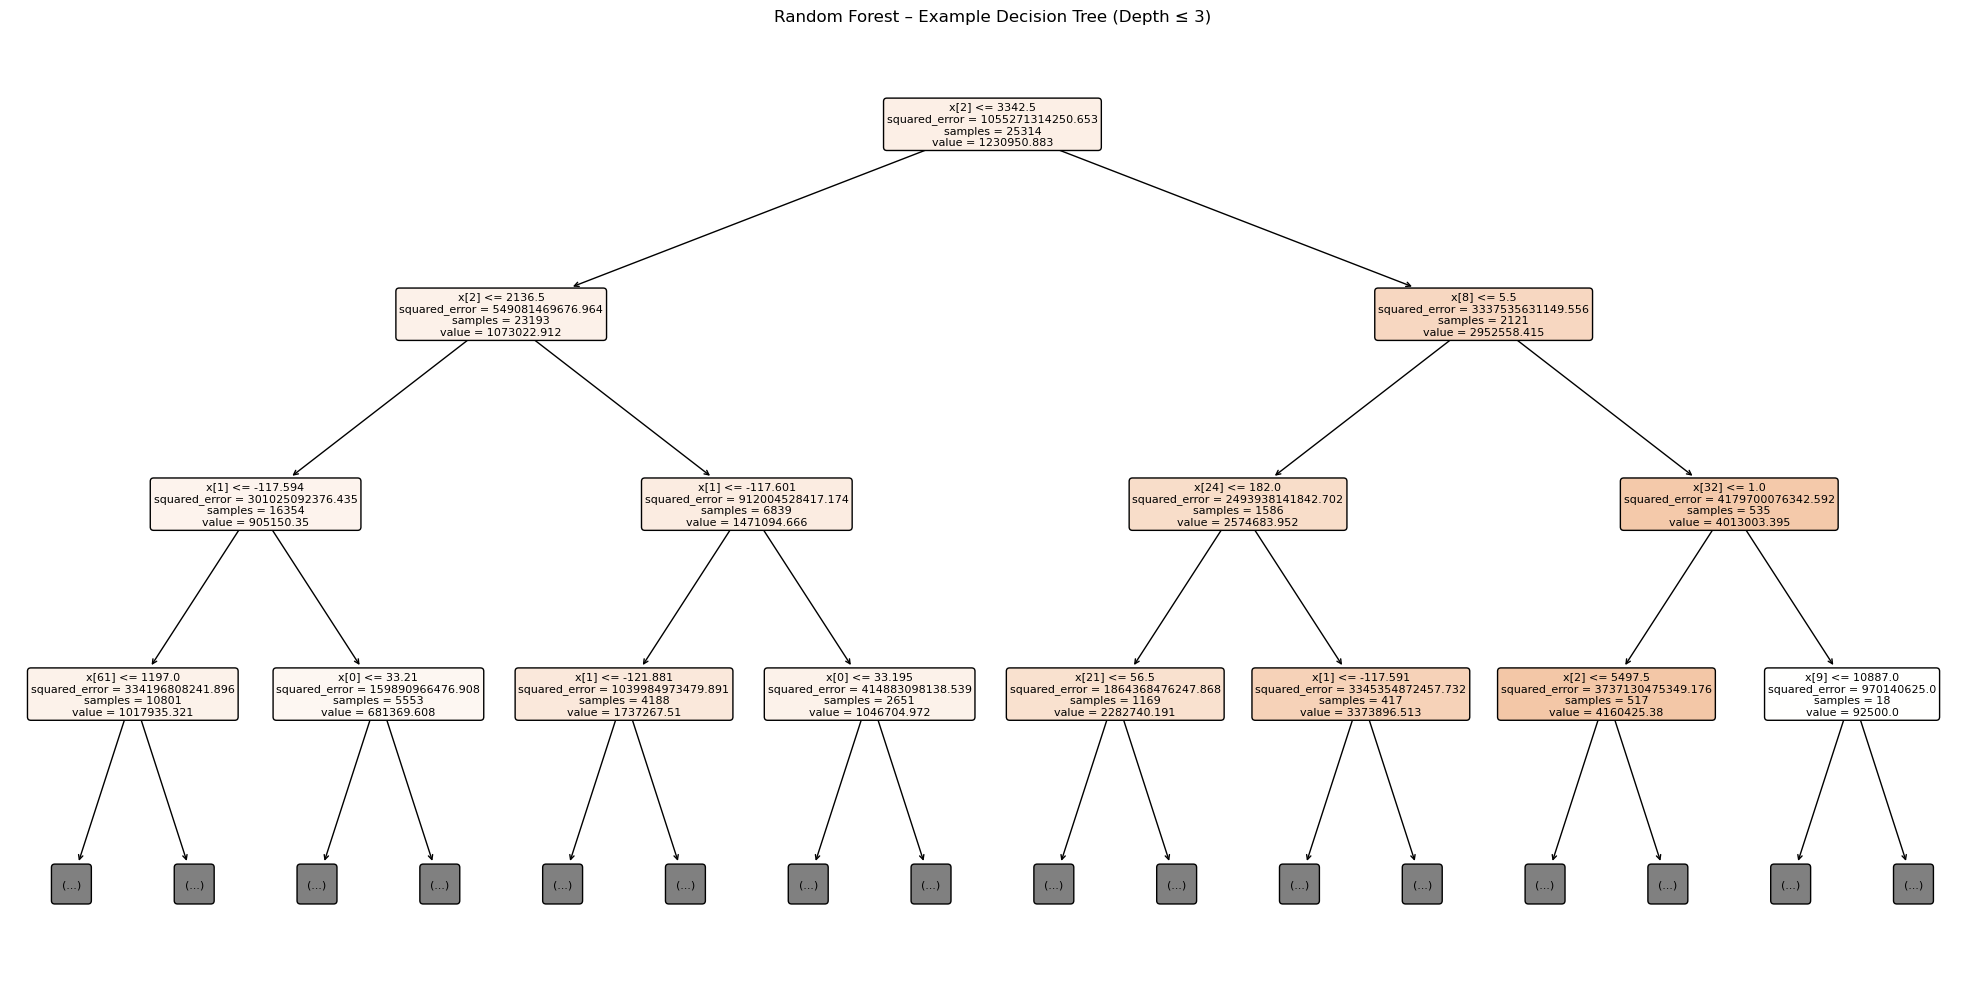

In [28]:
# Visualize one tree using matplotlib 
plt.figure(figsize=(20, 10))
tree.plot_tree(
    rf_model.estimators_[0],
    filled=True, 
    rounded=True,
    max_depth=3, # Keep this small to avoid crash (e.g., 3–4)
    fontsize=8
)
plt.title("Random Forest – Example Decision Tree (Depth ≤ 3)")
plt.tight_layout()
plt.show()

In [29]:
# Feature importance extraction and safety guard
importances = rf_model.feature_importances_

# Try to extract proper column names from the RF preprocessor
rf_pre = rf_tuned.named_steps["prep"]

try:
    feat_names_out = rf_pre.get_feature_names_out()
except Exception:
    # fallback: just use num_cols + cat_cols order
    feat_names_out = np.array(num_cols + cat_cols)
    
# Ensure lengths match (can happen if preprocessing drops some cols)
if len(importances) != len(feat_names_out):
    print(f"⚠️ Length mismatch: using generic names")
    feat_names_out = np.array([f"f{i}" for i in range(len(importances))])

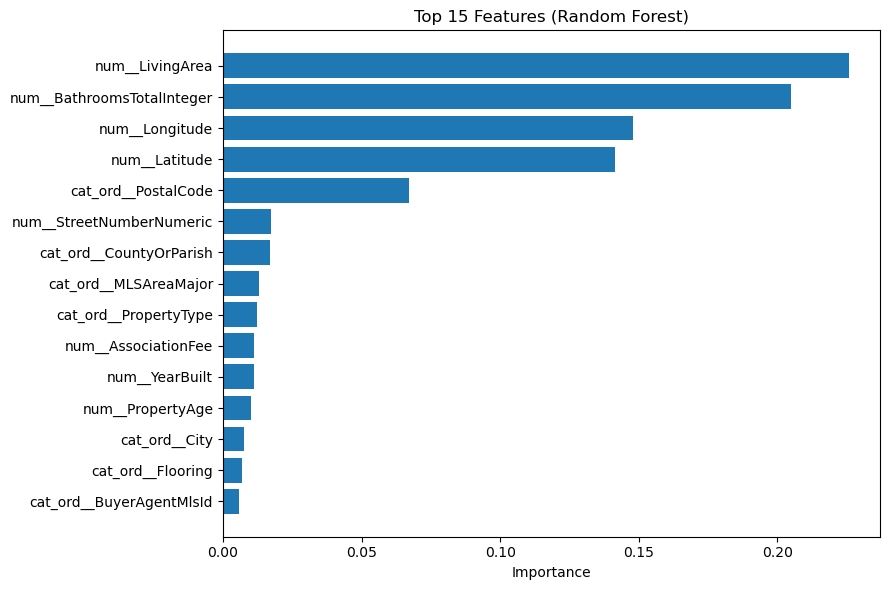

In [30]:
# Sort and display top importances
sorted_idx = np.argsort(importances)[::-1]
top_n = min(15, len(importances))

plt.figure(figsize=(9, 6))
plt.barh(range(top_n), importances[sorted_idx[:top_n]][::-1])
plt.yticks(range(top_n), feat_names_out[sorted_idx[:top_n]][::-1])
plt.xlabel("Importance")
plt.title(f"Top {top_n} Features (Random Forest)")
plt.tight_layout()
plt.show()

In [31]:
print("\nTop 10 features:")
for i in range(min(10, len(importances))):
    j = sorted_idx[i]
    print(f"  {feat_names_out[j]:<30} {importances[j]:.4f}")


Top 10 features:
  num__LivingArea                0.2257
  num__BathroomsTotalInteger     0.2048
  num__Longitude                 0.1481
  num__Latitude                  0.1412
  cat_ord__PostalCode            0.0670
  num__StreetNumberNumeric       0.0173
  cat_ord__CountyOrParish        0.0170
  cat_ord__MLSAreaMajor          0.0130
  cat_ord__PropertyType          0.0121
  num__AssociationFee            0.0113


### Predict API

In [32]:
with open(models_path / "expected_feature_columns.json") as f:
    EXPECTED_COLS = json.load(f)

BEST_MODEL = joblib.load(models_path / "best_model.joblib")

def predict_price(raw_features: dict, model=BEST_MODEL):
    """Build a single-row DF with expected columns, then predict."""
    row = {c: raw_features.get(c, np.nan) for c in EXPECTED_COLS}
    X_new = pd.DataFrame([row], columns=EXPECTED_COLS)
    return float(model.predict(X_new)[0])

In [33]:
# Example new property --> I fill it with typical feature values from dataset
example_house = {
    "BedroomsTotal": 3,
    "BathroomsFull": 2,
    "LivingArea": 1600,
    "LotSizeArea": 5000,
    "GarageSpaces": 2,
    "YearBuilt": 1995,
    "PostalCode": "92618"
}
price = predict_price(example_house)
print(f"\nPredicted Close Price (example): ${price:,.0f}")

print("\n All done! Leakage fixed with time-based split and proper feature removal.")


Predicted Close Price (example): $955,564

 All done! Leakage fixed with time-based split and proper feature removal.


Using the trained Random Forest model, we can now predict the close price of a property 
given its characteristics (bedrooms, bathrooms, square footage, etc.).

This completes the full machine learning workflow from data cleaning, preprocessing, 
and model selection to training, evaluation, and final prediction.

#### 8. Inference Check

In [34]:
X_sample = X_test.head(5)
print("Predictions sample:", rf_tuned.predict(X_sample))

Predictions sample: [2778769.65634539 1909933.59516236 2207719.4943478  2751931.80414828
  583803.84733694]


#### Evaluate on the August 2025 holdout

In [35]:
print("AUGUST 2025 SPECIFIC EVALUATION")

# Reload full dataset to check for August 2025
df_full = pd.read_csv(csv_path)

# Find date column
date_col = None
for col in date_candidates:
    if col in df_full.columns:
        date_col = col
        break

if date_col is not None:
    # Parse date
    if date_col.lower() in {"period", "month", "salemonth"}:
        df_full["_parsed_date"] = df_full[date_col].astype(str).str.replace(r"[^\d]", "", regex=True)
        df_full["_date_sort"] = pd.to_datetime(df_full["_parsed_date"], format="%Y%m", errors="coerce")
    else:
        df_full["_date_sort"] = pd.to_datetime(df_full[date_col], errors="coerce")
    
    # Filter for August 2025
    df_full["_period"] = df_full["_date_sort"].dt.to_period('M')
    aug_2025_mask = df_full["_period"] == pd.Period("2025-08", freq='M')
    
    if aug_2025_mask.sum() > 0:
        print(f"Found {aug_2025_mask.sum()} August 2025 transactions")
        
        df_aug = df_full.loc[aug_2025_mask].copy()
        
        # Extract target
        y_aug_raw = pd.to_numeric(df_aug[target], errors="coerce")
        
        # Build feature matrix with expected columns
        X_aug = pd.DataFrame({c: df_aug.get(c, np.nan) for c in EXPECTED_COLS})
        
        # Keep only valid targets
        valid_mask = y_aug_raw.notna()
        X_aug = X_aug.loc[valid_mask].reset_index(drop=True)
        y_aug = y_aug_raw.loc[valid_mask].reset_index(drop=True)
        
        if len(y_aug) > 0:
            print(f"{len(y_aug)} valid transactions for evaluation")
            
            # Predict
            y_aug_pred = BEST_MODEL.predict(X_aug)
            
            # Calculate metrics
            r2_aug = r2_score(y_aug, y_aug_pred)
            mae_aug = mean_absolute_error(y_aug, y_aug_pred)
            rmse_aug = mean_squared_error(y_aug, y_aug_pred, squared=False)
            mdape_aug = mdape(y_aug, y_aug_pred)
            
            print("\n August 2025 Performance:")
            print(f"R²: {r2_aug:.4f}")
            print(f"MAE: ${mae_aug:,.0f}")
            print(f"RMSE: ${rmse_aug:,.0f}")
            print(f"MdAPE: {mdape_aug:.2f}%")
            print(f"n: {len(y_aug)} transactions")
            
            # Save August 2025 specific results
            aug_results = {
                "month": "2025-08",
                "n_transactions": int(len(y_aug)),
                "R2": float(r2_aug),
                "MAE": float(mae_aug),
                "RMSE": float(rmse_aug),
                "MdAPE": float(mdape_aug)
            }
            
            with open(models_path / "august_2025_evaluation.json", "w") as f:
                json.dump(aug_results, f, indent=2)
            
            print(f"\n Saved August 2025 results → {models_path / 'august_2025_evaluation.json'}")
        else:
            print("No valid target values for August 2025")
    else:
        print("No August 2025 data found in dataset")
        print("Skipping August-specific evaluation")
else:
    print("No date column found - skipping August 2025 evaluation")

AUGUST 2025 SPECIFIC EVALUATION
Found 11439 August 2025 transactions
11439 valid transactions for evaluation

 August 2025 Performance:
R²: 0.7947
MAE: $209,758
RMSE: $442,563
MdAPE: 10.47%
n: 11439 transactions

 Saved August 2025 results → ../models/august_2025_evaluation.json
